In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip3 install -U git+https://github.com/PYFTS/pyFTS
#!pip3 install SimpSOM
from keras.models import Model
from keras.layers import Dense, Input
from keras import regularizers, optimizers
from sklearn.preprocessing import MinMaxScaler
from pyFTS.benchmarks import Measures
import statistics
from pyFTS.common.Util import persist_obj, load_obj
from pyFTS.models.multivariate import common, variable, wmvfts
from pyFTS.partitioners import Grid
from pyFTS.common import Membership
import math
import pyFTS
import datetime
from pyFTS.common import Util

## Aux functions

In [6]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## Dataset Energy Appliances

In [8]:
df = pd.read_csv('HomeC.csv')
data = df.drop(labels=['icon','summary','cloudCover', 'House overall [kW]', 'time'], axis=1)
data = data.loc[0: : 10]
data

/home/luizfacury/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,use [kW],gen [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
0,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
10,1.585083,0.003417,0.000050,0.022100,0.678733,0.440200,0.121450,0.007433,0.013583,0.000350,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
20,0.533817,0.003450,0.000000,0.020633,0.062967,0.270033,0.004950,0.007033,0.013117,0.000750,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
30,1.190950,0.003083,0.000217,0.387400,0.061883,0.256867,0.004933,0.101783,0.012533,0.000700,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
40,1.582083,0.003067,0.000050,0.022050,0.681717,0.242433,0.005550,0.122400,0.013550,0.000567,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503870,0.896250,0.004150,0.000233,0.496633,0.063000,0.042317,0.123800,0.007850,0.012433,0.000467,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503880,1.311617,0.004167,0.000017,0.359167,0.645433,0.041917,0.005133,0.008167,0.013083,0.000650,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503890,2.059367,0.003383,0.000033,0.153367,0.643300,0.042050,0.005117,0.008283,0.013267,0.000433,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503900,1.522583,0.003200,0.000067,0.023033,0.627233,0.041767,0.005283,0.008433,0.013533,0.000467,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51


In [9]:
values = data.values
values

array([[9.32833333e-01, 3.48333300e-03, 3.33000000e-05, ...,
        0.00000000e+00, 2.44000000e+01, 0.00000000e+00],
       [1.58508333e+00, 3.41666700e-03, 5.00000000e-05, ...,
        0.00000000e+00, 2.44000000e+01, 0.00000000e+00],
       [5.33816667e-01, 3.45000000e-03, 0.00000000e+00, ...,
        0.00000000e+00, 2.44000000e+01, 0.00000000e+00],
       ...,
       [2.05936667e+00, 3.38333300e-03, 3.33000000e-05, ...,
        1.01000000e-02, 3.12700000e+01, 5.10000000e-01],
       [1.52258333e+00, 3.20000000e-03, 6.67000000e-05, ...,
        1.01000000e-02, 3.12700000e+01, 5.10000000e-01],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

### Dataset Energy Appliances: columns

In [10]:
cols = data.columns
list_cols = list(cols)
list_cols.append('use [kW]_t+1')
print(list_cols)

['use [kW]', 'gen [kW]', 'Dishwasher [kW]', 'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]', 'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]', 'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]', 'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature', 'humidity', 'visibility', 'apparentTemperature', 'pressure', 'windSpeed', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability', 'use [kW]_t+1']


### Dataset Energy Appliance: Preprocessing, Lag = 1, t+1

In [11]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[28:54], axis=1, inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var27(t-1),var1(t)
1,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,1.585083
2,1.585083,0.003417,0.000050,0.022100,0.678733,0.440200,0.121450,0.007433,0.013583,0.000350,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,0.533817
3,0.533817,0.003450,0.000000,0.020633,0.062967,0.270033,0.004950,0.007033,0.013117,0.000750,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,1.190950
4,1.190950,0.003083,0.000217,0.387400,0.061883,0.256867,0.004933,0.101783,0.012533,0.000700,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,1.582083
5,1.582083,0.003067,0.000050,0.022050,0.681717,0.242433,0.005550,0.122400,0.013550,0.000567,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,0.837000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50386,1.068350,0.004183,0.000100,0.021550,0.639333,0.041650,0.005350,0.020400,0.013450,0.000567,...,0.82,8.00,29.71,1011.87,7.82,196.0,0.0106,31.01,0.51,1.621417
50387,1.621417,0.004183,0.000033,0.441950,0.645467,0.041767,0.129317,0.008067,0.012883,0.000317,...,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51,0.896250
50388,0.896250,0.004150,0.000233,0.496633,0.063000,0.042317,0.123800,0.007850,0.012433,0.000467,...,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51,1.311617
50389,1.311617,0.004167,0.000017,0.359167,0.645433,0.041917,0.005133,0.008167,0.013083,0.000650,...,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51,2.059367


In [12]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)',
       'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var19(t-1)', 'var20(t-1)',
       'var21(t-1)', 'var22(t-1)', 'var23(t-1)', 'var24(t-1)', 'var25(t-1)',
       'var26(t-1)', 'var27(t-1)', 'var1(t)'],
      dtype='object')

In [13]:
reframed.dropna()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var27(t-1),var1(t)
1,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,1.585083
2,1.585083,0.003417,0.000050,0.022100,0.678733,0.440200,0.121450,0.007433,0.013583,0.000350,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,0.533817
3,0.533817,0.003450,0.000000,0.020633,0.062967,0.270033,0.004950,0.007033,0.013117,0.000750,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,1.190950
4,1.190950,0.003083,0.000217,0.387400,0.061883,0.256867,0.004933,0.101783,0.012533,0.000700,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,1.582083
5,1.582083,0.003067,0.000050,0.022050,0.681717,0.242433,0.005550,0.122400,0.013550,0.000567,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,0.837000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50386,1.068350,0.004183,0.000100,0.021550,0.639333,0.041650,0.005350,0.020400,0.013450,0.000567,...,0.82,8.00,29.71,1011.87,7.82,196.0,0.0106,31.01,0.51,1.621417
50387,1.621417,0.004183,0.000033,0.441950,0.645467,0.041767,0.129317,0.008067,0.012883,0.000317,...,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51,0.896250
50388,0.896250,0.004150,0.000233,0.496633,0.063000,0.042317,0.123800,0.007850,0.012433,0.000467,...,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51,1.311617
50389,1.311617,0.004167,0.000017,0.359167,0.645433,0.041917,0.005133,0.008167,0.013083,0.000650,...,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51,2.059367


In [14]:
data = pd.DataFrame(reframed.values,columns=list_cols)
data

,use [kW],gen [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],...,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability,use [kW]_t+1
0,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,1.585083
1,1.585083,0.003417,0.000050,0.022100,0.678733,0.440200,0.121450,0.007433,0.013583,0.000350,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,0.533817
2,0.533817,0.003450,0.000000,0.020633,0.062967,0.270033,0.004950,0.007033,0.013117,0.000750,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,1.190950
3,1.190950,0.003083,0.000217,0.387400,0.061883,0.256867,0.004933,0.101783,0.012533,0.000700,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,1.582083
4,1.582083,0.003067,0.000050,0.022050,0.681717,0.242433,0.005550,0.122400,0.013550,0.000567,...,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00,0.837000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50385,1.068350,0.004183,0.000100,0.021550,0.639333,0.041650,0.005350,0.020400,0.013450,0.000567,...,0.82,8.00,29.71,1011.87,7.82,196.0,0.0106,31.01,0.51,1.621417
50386,1.621417,0.004183,0.000033,0.441950,0.645467,0.041767,0.129317,0.008067,0.012883,0.000317,...,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51,0.896250
50387,0.896250,0.004150,0.000233,0.496633,0.063000,0.042317,0.123800,0.007850,0.012433,0.000467,...,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51,1.311617
50388,1.311617,0.004167,0.000017,0.359167,0.645433,0.041917,0.005133,0.008167,0.013083,0.000650,...,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51,2.059367


### Model: AutoencoderWeightedMVFTS - AE-MVFTS

In [15]:
# No treinamento eu recebo os dados de treino completo, a variável alvo e a epocas
# Faço o treinamento do AE e a redução dos dados de treino.
# Crio o modelo WMVFTS e treino ele com os dados "encodificados (com dimensão reduzida)" 
def train_reducted(train, Y, input_layers, output_layers, epochs):
    
    input_layer = Input(shape=(input_layers, ))
    encoder_layer_1 = Dense(50, activation="softsign",activity_regularizer=regularizers.l1(10e-5), kernel_initializer='normal')(input_layer)
    encoder_layer_2 = Dense(output_layers, activation="softsign",kernel_initializer='normal')(encoder_layer_1)

    decoder_layer_1 = Dense(50, activation="softsign",activity_regularizer=regularizers.l1(10e-5), kernel_initializer='normal')(encoder_layer_2)
    decoder_layer_2 = Dense(input_layers, activation="softsign", kernel_initializer='normal')(decoder_layer_1)

    autoencoder = Model(input_layer, decoder_layer_2)

    opt = optimizers.Adagrad(learning_rate=0.1)
    autoencoder.compile(optimizer = opt, loss='mse')
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train)
    autoencoder.fit(x=X_train, y=X_train, epochs=epochs, verbose=0, batch_size=40)

    encoder_model = Model(inputs=input_layer, outputs=encoder_layer_2)

    encoded_train = pd.DataFrame(encoder_model.predict(X_train))
    encoded_train.columns = ['factor_1', 'factor_2']
    encoded_train = encoded_train.join(Y)
    
    VX1= variable.Variable("factor_1", data_label="factor_1", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VX2= variable.Variable("factor_2", data_label="factor_2", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VY = variable.Variable("use", data_label="use [kW]_t+1", partitioner   = Grid.GridPartitioner, npart=50,   data=encoded_train ) 

    fts_model = pyFTS.models.multivariate.wmvfts.WeightedMVFTS(explanatory_variables=[VX1, VX2, VY], target_variable=VY)
    fts_model.fit(encoded_train)

    return fts_model, encoder_model, encoded_train


In [16]:
# No treino eu recebo o modelo WMVFTS treinado, o AE treinado, os dados te teste e a variável alvo
# Eu uso o AE treinado para reduzir a dimensão dos dados do treino
# Eu uso o WMVFTS treinado para fazer a previsão passando os dados de teste reduzidos
def forecast_reducted(fts_model, encoder_model,test, Y):
        
    scaler = MinMaxScaler()
    X_test = scaler.fit_transform(test)
    
    encoded_test = pd.DataFrame(encoder_model.predict(X_test))
    encoded_test.columns = ['factor_1', 'factor_2']
    encoded_test = encoded_test.join(Y)
    
    forecasts = fts_model.predict(encoded_test)

    return forecasts, encoded_test

In [17]:
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)

## Sliding Window PyFTS: AE-WMVFTS

--------------------
training window 0
[ 11:11:54] getting statistics


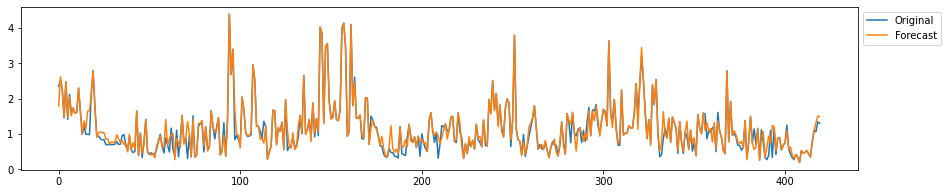

--------------------
training window 1679
[ 11:11:57] getting statistics


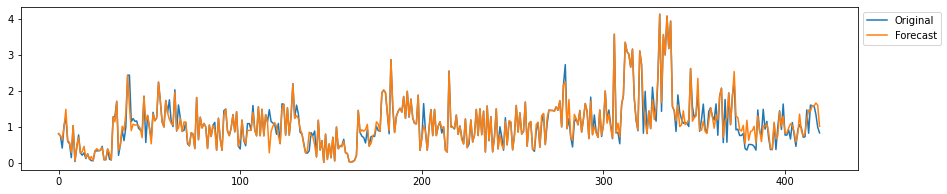

--------------------
training window 3358
[ 11:12:02] getting statistics


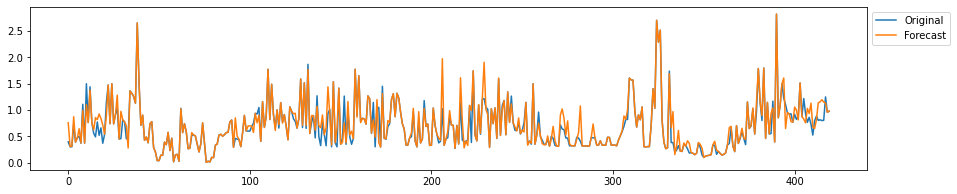

--------------------
training window 5037
[ 11:12:06] getting statistics


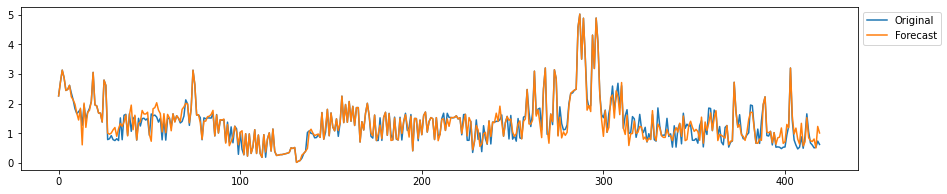

--------------------
training window 6716
[ 11:12:10] getting statistics


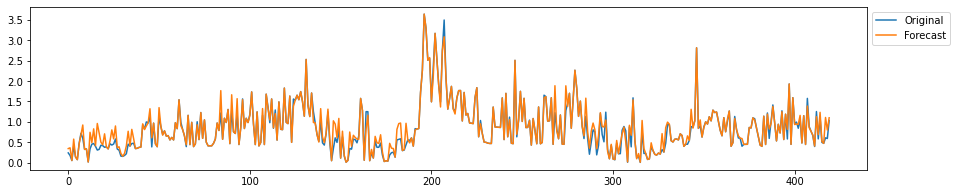

--------------------
training window 8395


/home/luizfacury/.local/lib/python3.9/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 11:12:14] getting statistics


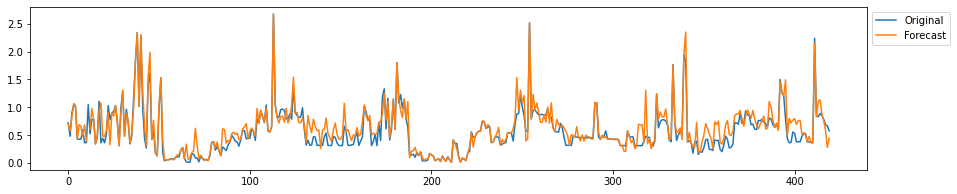

--------------------
training window 10074
[ 11:12:18] getting statistics


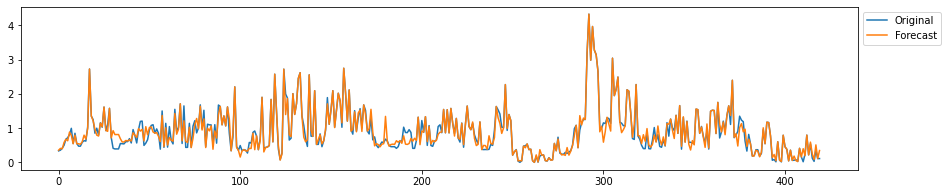

--------------------
training window 11753
[ 11:12:24] getting statistics


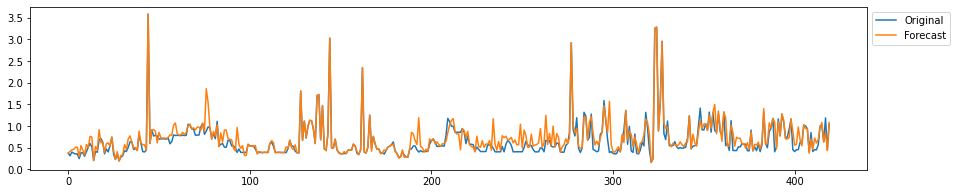

--------------------
training window 13432
[ 11:12:28] getting statistics


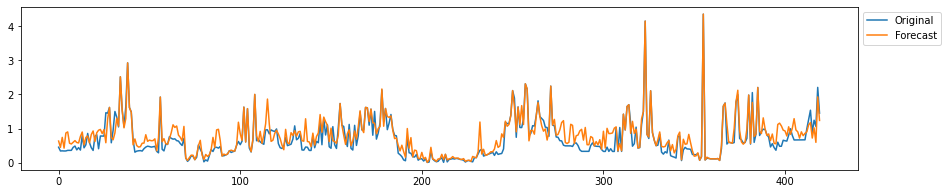

--------------------
training window 15111


/home/luizfacury/.local/lib/python3.9/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 11:12:32] getting statistics


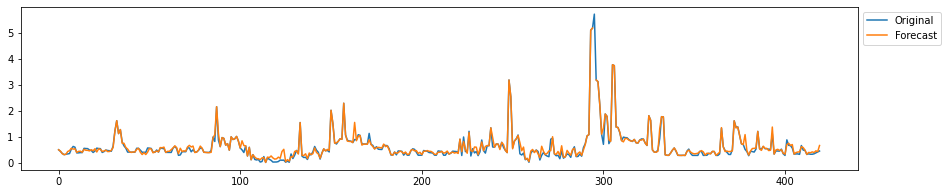

--------------------
training window 16790
[ 11:12:38] getting statistics


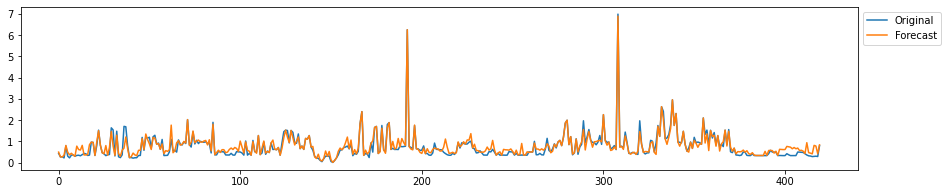

--------------------
training window 18469
[ 11:12:42] getting statistics


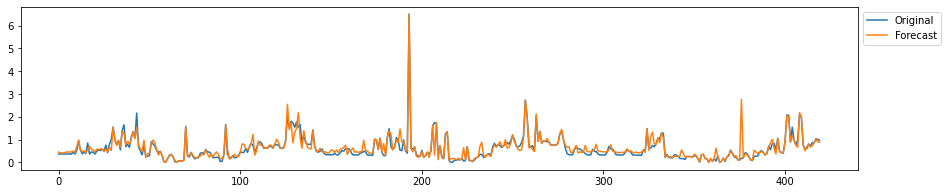

--------------------
training window 20148
[ 11:12:46] getting statistics


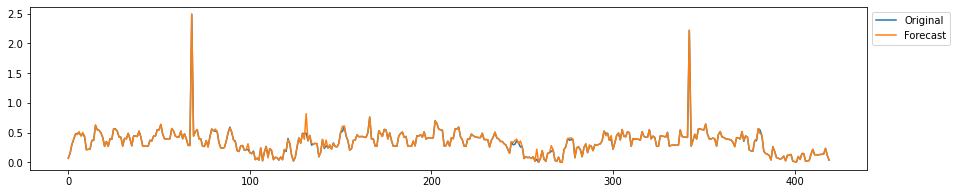

--------------------
training window 21827
[ 11:12:50] getting statistics


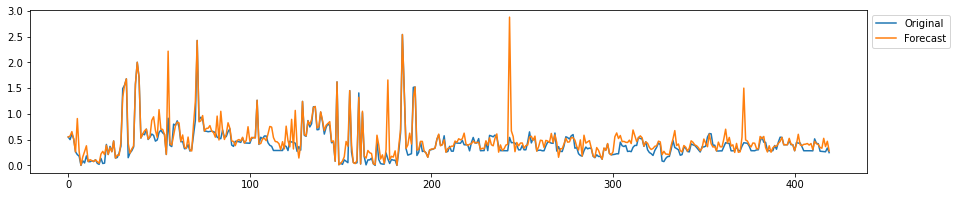

--------------------
training window 23506
[ 11:12:54] getting statistics


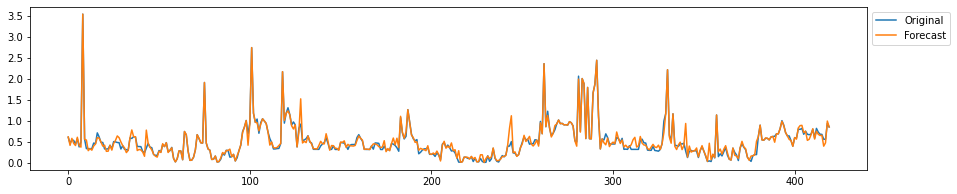

--------------------
training window 25185
[ 11:13:01] getting statistics


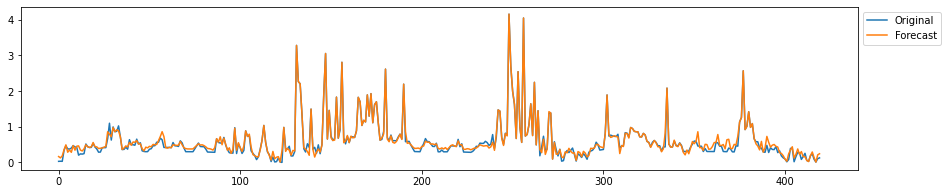

--------------------
training window 26864


/home/luizfacury/.local/lib/python3.9/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 11:13:05] getting statistics


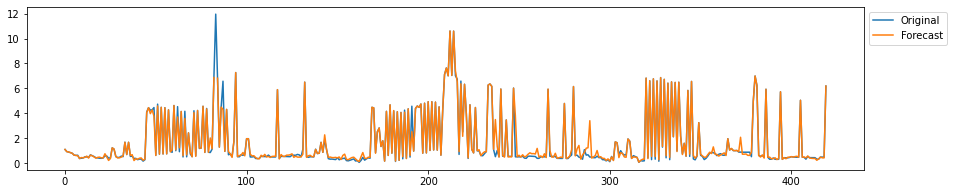

--------------------
training window 28543
[ 11:13:08] getting statistics


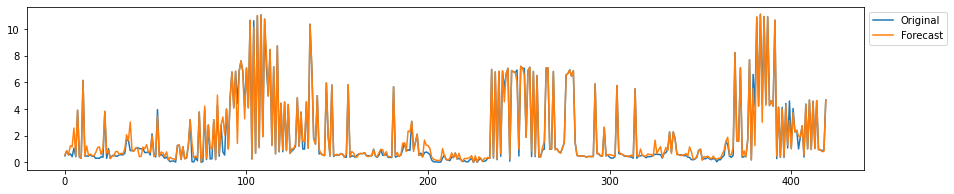

--------------------
training window 30222
[ 11:13:15] getting statistics


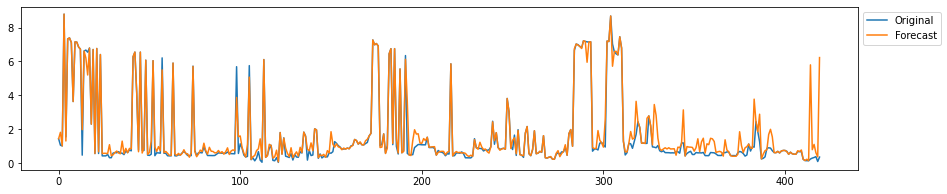

--------------------
training window 31901
[ 11:13:19] getting statistics


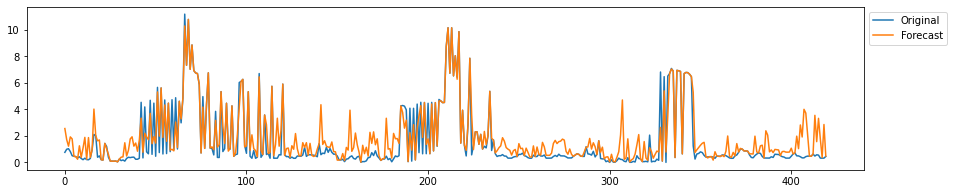

--------------------
training window 33580
[ 11:13:23] getting statistics


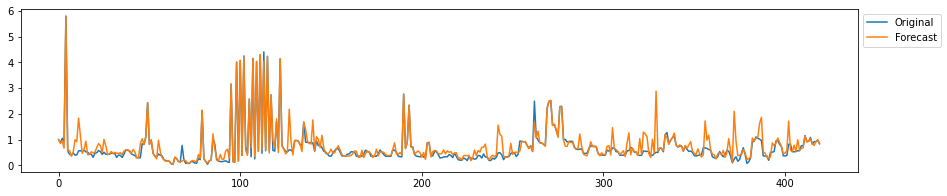

--------------------
training window 35259
[ 11:13:29] getting statistics


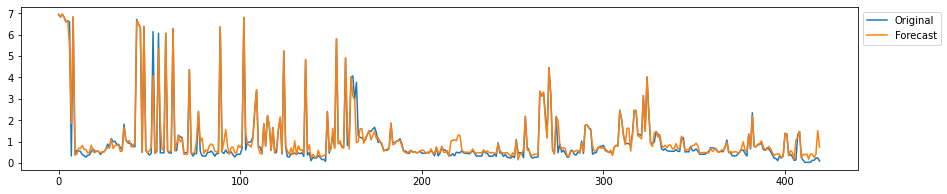

--------------------
training window 36938
[ 11:13:34] getting statistics


/home/luizfacury/.local/lib/python3.9/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


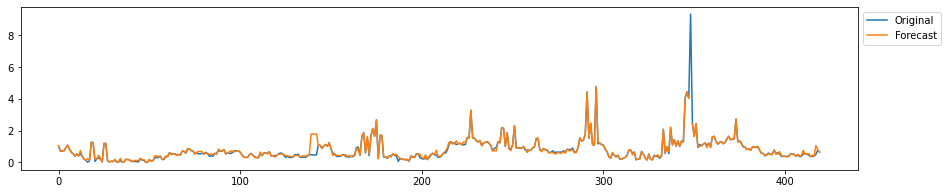

--------------------
training window 38617
[ 11:13:38] getting statistics


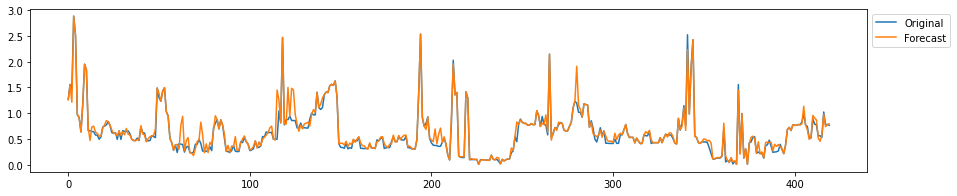

--------------------
training window 40296


/home/luizfacury/.local/lib/python3.9/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 11:13:44] getting statistics


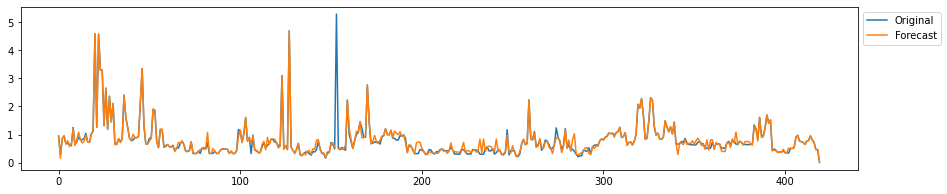

--------------------
training window 41975
[ 11:13:48] getting statistics


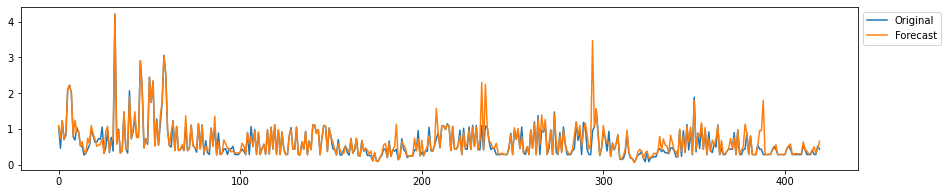

--------------------
training window 43654
[ 11:13:53] getting statistics


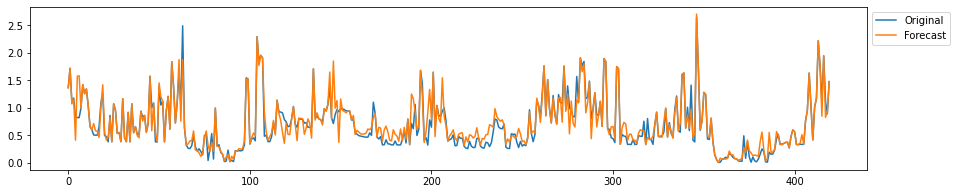

--------------------
training window 45333
[ 11:14:00] getting statistics


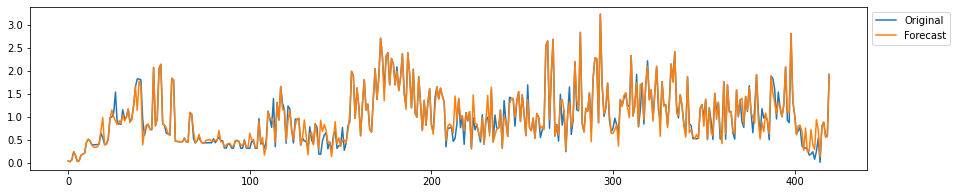

--------------------
training window 47012
[ 11:14:06] getting statistics


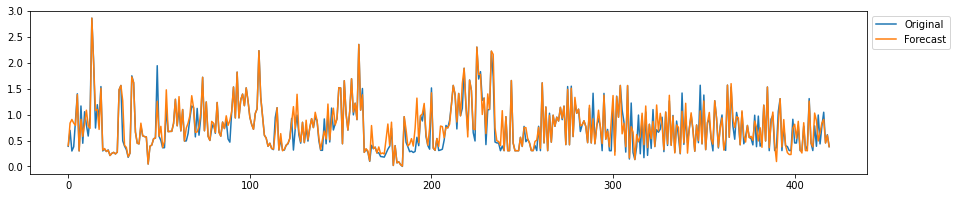

--------------------
training window 48691
[ 11:14:10] getting statistics


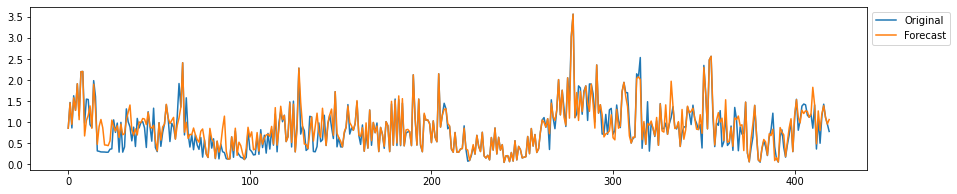

In [20]:
input_layers = 27
output_layers = 2 
epocs = 50

result = {
     "window": [],
     "rmse": [],
     "nrmse": [],
     "mape": [],
     "smape": []
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        appliance = ttest['use [kW]_t+1'].reset_index()
        appliance_train = ttrain['use [kW]_t+1'].reset_index()
        print('-' * 20)
        print(f'training window {(ct)}')
        # Faz o treinamento 
        fts_model, encoder_model, encoded_train = train_reducted(ttrain.loc[:,'use [kW]':'precipProbability'], 
                                                                 appliance_train, input_layers,
                                                                 output_layers, epocs)
        # Faz o teste 
        forecast, encoded_test = forecast_reducted(fts_model, encoder_model,ttest.loc[:,'use [kW]':'precipProbability'],
                                                   appliance)
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        appliance.pop('index')
        encoded_test.pop('index')
        rmse = Measures.rmse(encoded_test['use [kW]_t+1'].values.tolist(),forecast)
        nrmse = cal_nrmse(rmse, appliance.values.tolist())
        mape = Measures.mape(encoded_test['use [kW]_t+1'].values.tolist(),forecast)
        smape = Measures.smape(encoded_test['use [kW]_t+1'].values.tolist(),forecast)
        
        #forecasts.append(forecast)
        #appliances.append(appliance)
        
        result["rmse"].append(rmse)
        result["nrmse"].append(nrmse)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["window"].append(ct)
        
        # Grafico de comparação Original x Previsto para cada janela
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(encoded_test['use [kW]_t+1'], label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()

measures = pd.DataFrame(result)



In [21]:
measures

,window,rmse,nrmse,mape,smape
0,0,0.180743,[0.04303036232802181],13.495280,5.427222
1,1679,0.186669,[0.04533963623737703],11.934664,5.097155
2,3358,0.146854,[0.05228663119165576],11.416257,4.665921
3,5037,0.214542,[0.04286061642268418],13.233584,6.078898
4,6716,0.136236,[0.037484746184336934],12.422880,4.749145
5,8395,0.163195,[0.06125226925120605],32.952265,10.357398
6,10074,0.146546,[0.033884748725796186],23.321994,7.132518
7,11753,0.175288,[0.05118333301186225],18.843607,7.550583
8,13432,0.245264,[0.05639820303149158],44.689828,14.519697
9,15111,0.102053,[0.01792975662820837],20.346501,6.979027


### Mean Statistics AE-WMVFTS

In [38]:
final_result = {
     "rmse": [],
     "nrmse": [],
     "mape": [],
     "smape": []
}

final_result["rmse"].append(statistics.mean(measures['rmse']))
final_result["nrmse"].append(measures['nrmse'].mean()[0])
final_result["mape"].append(statistics.mean(measures['mape']))
final_result["smape"].append(statistics.mean(measures['smape']))
        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics AE-WMVFTS (test): ")
final_measures_pca

Mean Statistics AE-WMVFTS (test): 


,rmse,nrmse,mape,smape
0,0.224236,0.043764,53.417932,8.529083


In [36]:
measures['nrmse'].mean()

array([0.04376364])